**Method**

- Implementing a Transformer-based Seq2Seq architecture, my model diverges from the original Transformer approach by using Recurrent Neural Network (RNN) for processing both input and output. The SMILES string's individual characters are initially mapped to integers, passed to an Embedding layer to map them to a higher dimension before input to the Encoder.

- Encoder: The input is passed through a Self-Attention layer, enabling the model to learn relationships between atoms and bonds within the SMILES structure. The output self-attention is then concatenated with the original input and directed to an LSTM layer. The LSTM sequentially processes the input, producing hidden states at each time step, and a final state which contain all the necessary information. All hidden states and final state are input to the Decoder.

- Decoder: The last hidden state from the Encoder serves as the first hidden state of the Decoder, functioning as the Query. Employing a Cross-Attention layer (Bahdanau Attention) to let Decoder focuses on necessary hidden states in all the hidden states from the Encoder for each steps. The acquired attention is concatenated with previous Decoder time steps to predict the subsequent output.

In [1]:
DIM_MODEL = 128
NUM_BLOCK = 1
NUM_HEAD = 4
DROPOUT = 0.5
FE = 1

BATCH_SIZE = 16
NUM_EPOCHS = 50
TEACHER_FORCING_RATE = 0.0
LEARNING_RATE = 0.001
PATIENCE_THRESHOLD = 4
ATTENTION_IMAGE_OUTPUT_PATH = 'attention-image'

SMILES_PATH = '../data/ADAGRASIB_SMILES.txt'
COORDINATE_PATH = '../data/ADAGRASIB_COOR.sdf'

ENCODER_PATH = './trained-model/Encoder-D128-B1-H4-FE1-DROPOUT0.5.pth'
DECODER_PATH = './trained-model/Decoder-D128-B1-H4-FE1-DROPOUT0.5.pth'

In [2]:
from torch.utils.data import Dataset, DataLoader 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")
import utils
from utils import *
from model import * 

In [3]:
smi_list = get_smi(SMILES_PATH)
longest_smi = get_longest(smi_list)
smi_dic = get_dic(smi_list)
inv_smi_dic = {value:key for key, value in smi_dic.items()}
smint_list = [smi2int(smi, smi_dic, longest_smi) for smi in smi_list]


coor_list = get_coor(COORDINATE_PATH)
longest_coor = get_longest(coor_list)
np_coor_list = pad_coor(normalize_coor(coor_list), longest_coor)

In [4]:
encoder = Encoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=NUM_HEAD,
                  dropout=DROPOUT,
                  fe = FE,
                  len_dic=len(smi_dic)).to(device)

decoder = Decoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=NUM_HEAD,
                  dropout=DROPOUT,
                  fe=FE,
                  longest_coor=longest_coor,
                  ).to(device)

In [5]:
encoder.load_state_dict(torch.load(ENCODER_PATH))
decoder.load_state_dict(torch.load(DECODER_PATH))

<All keys matched successfully>

--------------------------------------------------------------------------
**Run the below cell to test the model on a random input in the dataset**
--------------------------------------------------------------------------

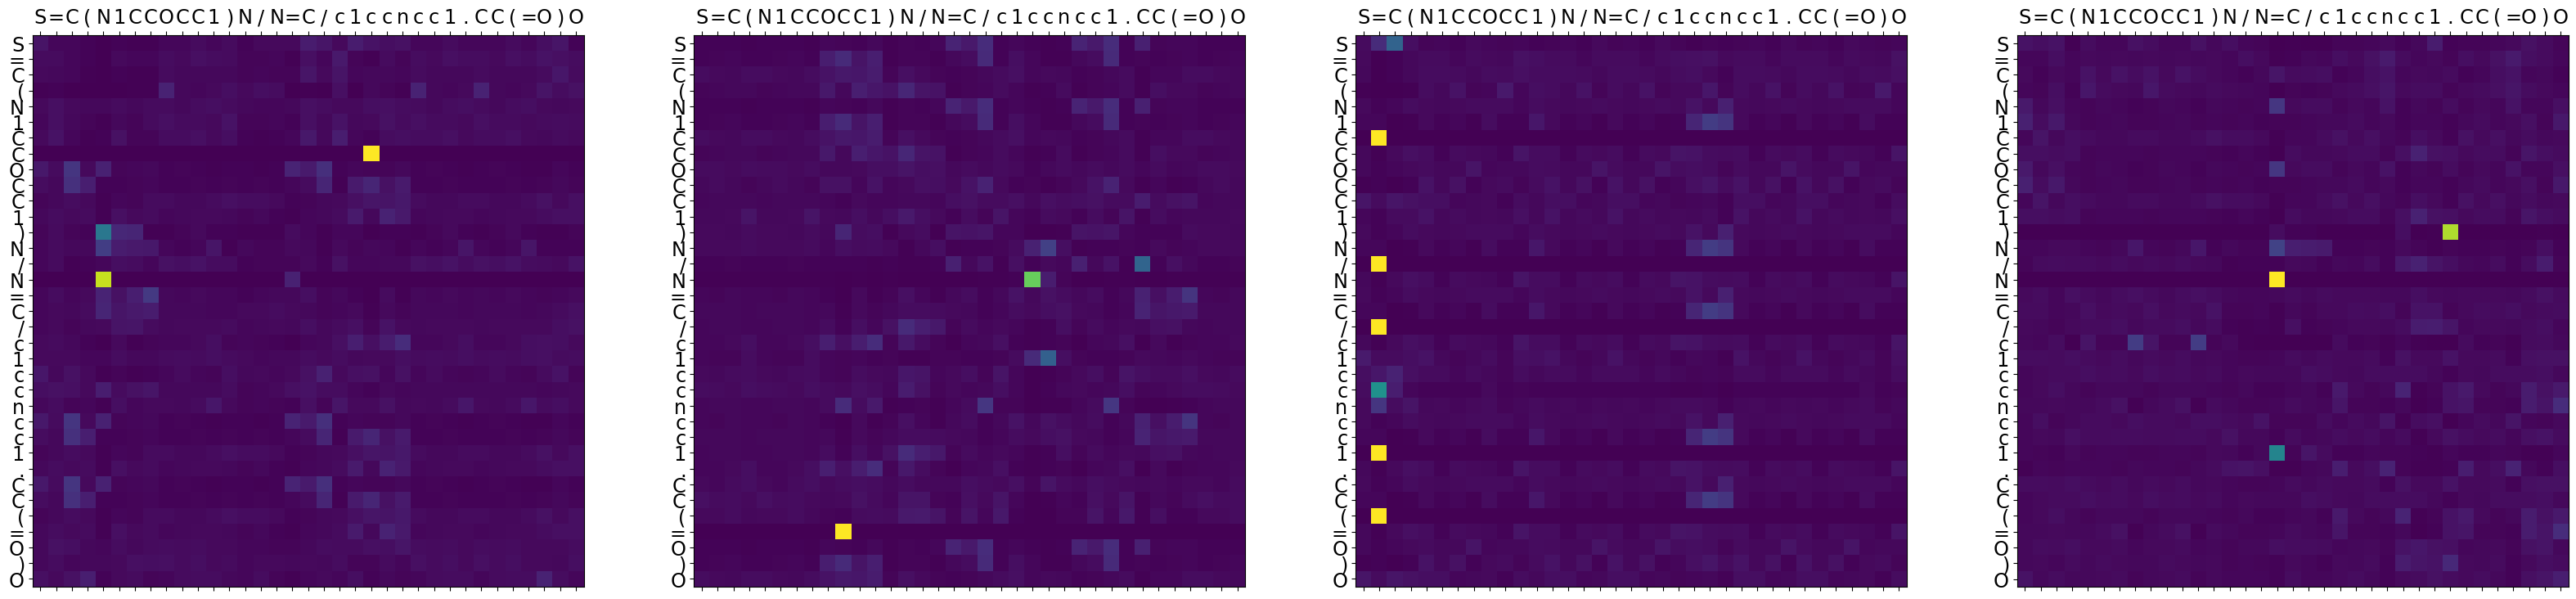

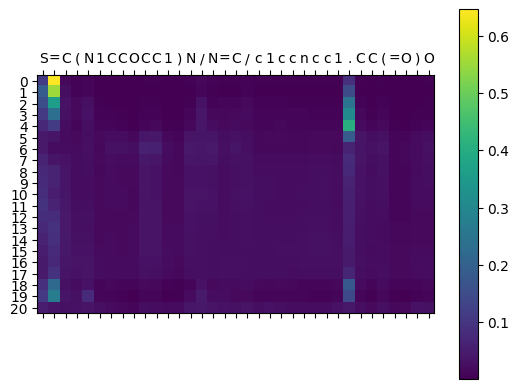

Input SMILES: S=C(N1CCOCC1)N/N=C/c1ccncc1.CC(=O)O


Target: [0.0, 0.0, 0.0]  |  Predicted: [-0.03, 0.48, -0.06]
Target: [-0.51, 1.59, -0.36]  |  Predicted: [0.23, 1.29, -0.17]
Target: [0.19, 2.34, -1.24]  |  Predicted: [1.15, 2.19, -0.16]
Target: [0.08, 3.81, -1.25]  |  Predicted: [2.04, 2.65, -0.1]
Target: [1.49, 4.4, -1.29]  |  Predicted: [2.4, 2.93, -0.1]
Target: [2.19, 3.88, -2.42]  |  Predicted: [1.87, 3.04, -0.18]
Target: [2.43, 2.49, -2.18]  |  Predicted: [0.82, 2.57, -0.22]
Target: [1.11, 1.73, -2.21]  |  Predicted: [-0.49, 2.01, -0.24]
Target: [-1.62, 2.09, 0.22]  |  Predicted: [-1.52, 1.72, -0.25]
Target: [-2.11, 3.34, -0.18]  |  Predicted: [-2.32, 1.55, -0.27]
Target: [-3.18, 3.83, 0.38]  |  Predicted: [-3.05, 1.41, -0.29]
Target: [-3.7, 5.14, -0.03]  |  Predicted: [-3.72, 1.48, -0.29]
Target: [-4.85, 5.68, 0.56]  |  Predicted: [-4.26, 1.6, -0.22]
Target: [-5.3, 6.92, 0.14]  |  Predicted: [-4.84, 1.72, -0.16]
Target: [-4.66, 7.59, -0.8]  |  Predicted: [-5.41, 1.84, -0.15]
Ta

In [7]:
r = random.randint(0, len(smi_list))

visualize(smi_list[r], encoder, decoder, smi_dic, longest_smi, output_path=ATTENTION_IMAGE_OUTPUT_PATH, output_name=f"test")
prediction, _, _ = evaluate(smi_list[r], encoder, decoder, smi_dic, longest_smi)

print(f'Input SMILES: {replace_atom(smi_list[r][:-1], mode="eval")}\n\n')



for target, predicted in zip(np_coor_list[r], prediction):
    print(f'Target: {[round(i.item(),2) for i in target]}  |  Predicted: {[round(i,2) for i in predicted]}')